# <center> Задача распознавания людей на аэросъемке

Данные, представленные компанией, оказались:

1. Не полными. В данных недостаточно изображений людей.


2. Не размеченными. На них невозможно обучать модели image segmentation.

## План работы

1. Поиск размеченного набора данных с аэросъемки, где присутствуют люди и лес.


2. Обучение на этих данных популярных архитектур image segmentation.


3. Адаптация арихтектур к задаче people detection.


4. Разметка предоставленного набора данных с помощью обученных моделей.


5. Решение задачи people detection на размеченном исходном датасете.

## 1. Данные

Dataset Resource: https://www.tugraz.at/index.php?id=22387

Citation
If you use this dataset in your research, please cite the following URL:

http://dronedataset.icg.tugraz.at

License
The Drone Dataset is made freely available to academic and non-academic entities for non-commercial purposes such as academic research, teaching, scientific publications, or personal experimentation. Permission is granted to use the data given that you agree:

That the dataset comes "AS IS", without express or implied warranty. Although every effort has been made to ensure accuracy, we (Graz University of Technology) do not accept any responsibility for errors or omissions.
That you include a reference to the Semantic Drone Dataset in any work that makes use of the dataset. For research papers or other media link to the Semantic Drone Dataset webpage.
That you do not distribute this dataset or modified versions. It is permissible to distribute derivative works in as far as they are abstract representations of this dataset (such as models trained on it or additional annotations that do not directly include any of our data) and do not allow to recover the dataset or something similar in character.
That you may not use the dataset or any derivative work for commercial purposes as, for example, licensing or selling the data, or using the data with a purpose to procure a commercial gain.
That all rights not expressly granted to you are reserved by us (Graz University of Technology).

Dataset Overview
The Semantic Drone Dataset focuses on semantic understanding of urban scenes for increasing the safety of autonomous drone flight and landing procedures. The imagery depicts more than 20 houses from nadir (bird's eye) view acquired at an altitude of 5 to 30 meters above ground. A high resolution camera was used to acquire images at a size of 6000x4000px (24Mpx). The training set contains 400 publicly available images and the test set is made up of 200 private images.

PERSON DETECTION
For the task of person detection the dataset contains bounding box annotations of the training and test set.

SEMANTIC SEGMENTATION
We prepared pixel-accurate annotation for the same training and test set. The complexity of the dataset is limited to 20 classes as listed in the following table.

Table 1: Semanic classes of the Drone Dataset

tree, gras, other vegetation, dirt, gravel, rocks, water, paved area, pool, person, dog, car, bicycle, roof, wall, fence, fence-pole, window, door, obstacle

In [70]:
import numpy as np
import pandas as pd

import pickle
import random
import six

from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

from os import listdir

from keras_segmentation.models.unet import vgg_unet

Для каждого изображения имеется размеченное изображение. Объекты разных клссов подсвечены разными цветами.

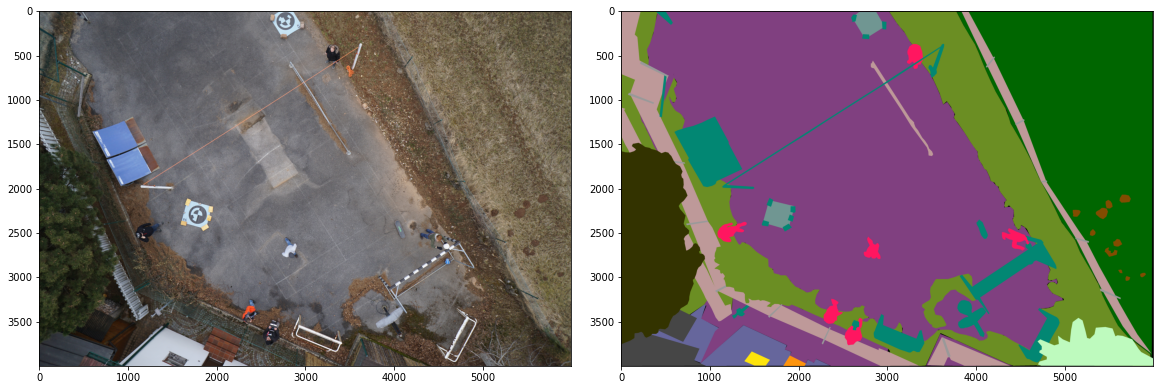

In [8]:
original_image = "semantic_drone_dataset/training_set/images/001.jpg"
label_image_semantic = "semantic_drone_dataset/training_set/gt/semantic/label_images/001.png"

fig, axs = plt.subplots(1, 2, figsize=(16, 8), constrained_layout=True)

axs[0].imshow( Image.open(original_image))
axs[0].grid(False)

label_image_semantic = Image.open(label_image_semantic)
label_image_semantic = np.asarray(label_image_semantic)
axs[1].imshow(label_image_semantic)
axs[1].grid(False)

Номера изображений, на которых есть люди. Заданы области, то есть набор данных размечен для задачи сегментации.

In [4]:
with open('semantic_drone_dataset/training_set/gt/bounding_box/bounding_boxes/person/imgIdToBBoxArray.p', 'rb') as pickleFile:
        x = pickle.load(pickleFile)

In [33]:
x[list(x.keys())[0]] # координаты людей на конкретном изображении

[array([[2.940e+03, 1.000e+00],
        [3.071e+03, 8.800e+01]]),
 array([[3045.,  603.],
        [3317., 1158.]]),
 array([[4610., 2158.],
        [5271., 2540.]]),
 array([[5743., 2045.],
        [5999., 2340.]])]

Цвета классов заданы следующим образом. Всего имеется 23 класса объектов для распознавания.

In [12]:
classes_data = pd.read_csv('semantic_drone_dataset/training_set/gt/semantic/class_dict.csv')
classes_data

,name,r,g,b
0,unlabeled,0,0,0
1,paved-area,128,64,128
2,dirt,130,76,0
3,grass,0,102,0
4,gravel,112,103,87
5,water,28,42,168
6,rocks,48,41,30
7,pool,0,50,89
8,vegetation,107,142,35
9,roof,70,70,70


Всего имеется 400 размеченных изображений.

In [15]:
image_names = listdir('semantic_drone_dataset/training_set/images')
label_image_names= listdir('semantic_drone_dataset/training_set/gt/semantic/label_images/')

In [18]:
len(image_names), len(label_image_names)

(400, 400)

## 2. Решение задачи сегментации

## 2.1 Unet

In [77]:
import cv2
import numpy as np

ann_img = np.zeros((30,30,3)).astype('uint8')
ann_img[ 3 , 4 ] = 1 # this would set the label of pixel 3,4 as 1
ann_img[ 0 , 0 ] = 2 # this would set the label of pixel 0,0 as 2

In [78]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import keras
from keras.models import *
from keras.layers import *

from types import MethodType
import random
import six
import json
from tqdm import tqdm
import cv2
import numpy as np
import itertools

In [79]:
import sys
print(sys.version)

3.8.2 (default, Apr 27 2020, 15:53:34) 
[GCC 9.3.0]


In [1]:
from tensorflow import keras

In [2]:
model1 = keras.models.load_model('1.h5')

In [4]:
model1.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 416, 608, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 416, 608, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 416, 608, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 208, 304, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

In [3]:
from keras.utils.vis_utils import plot_model

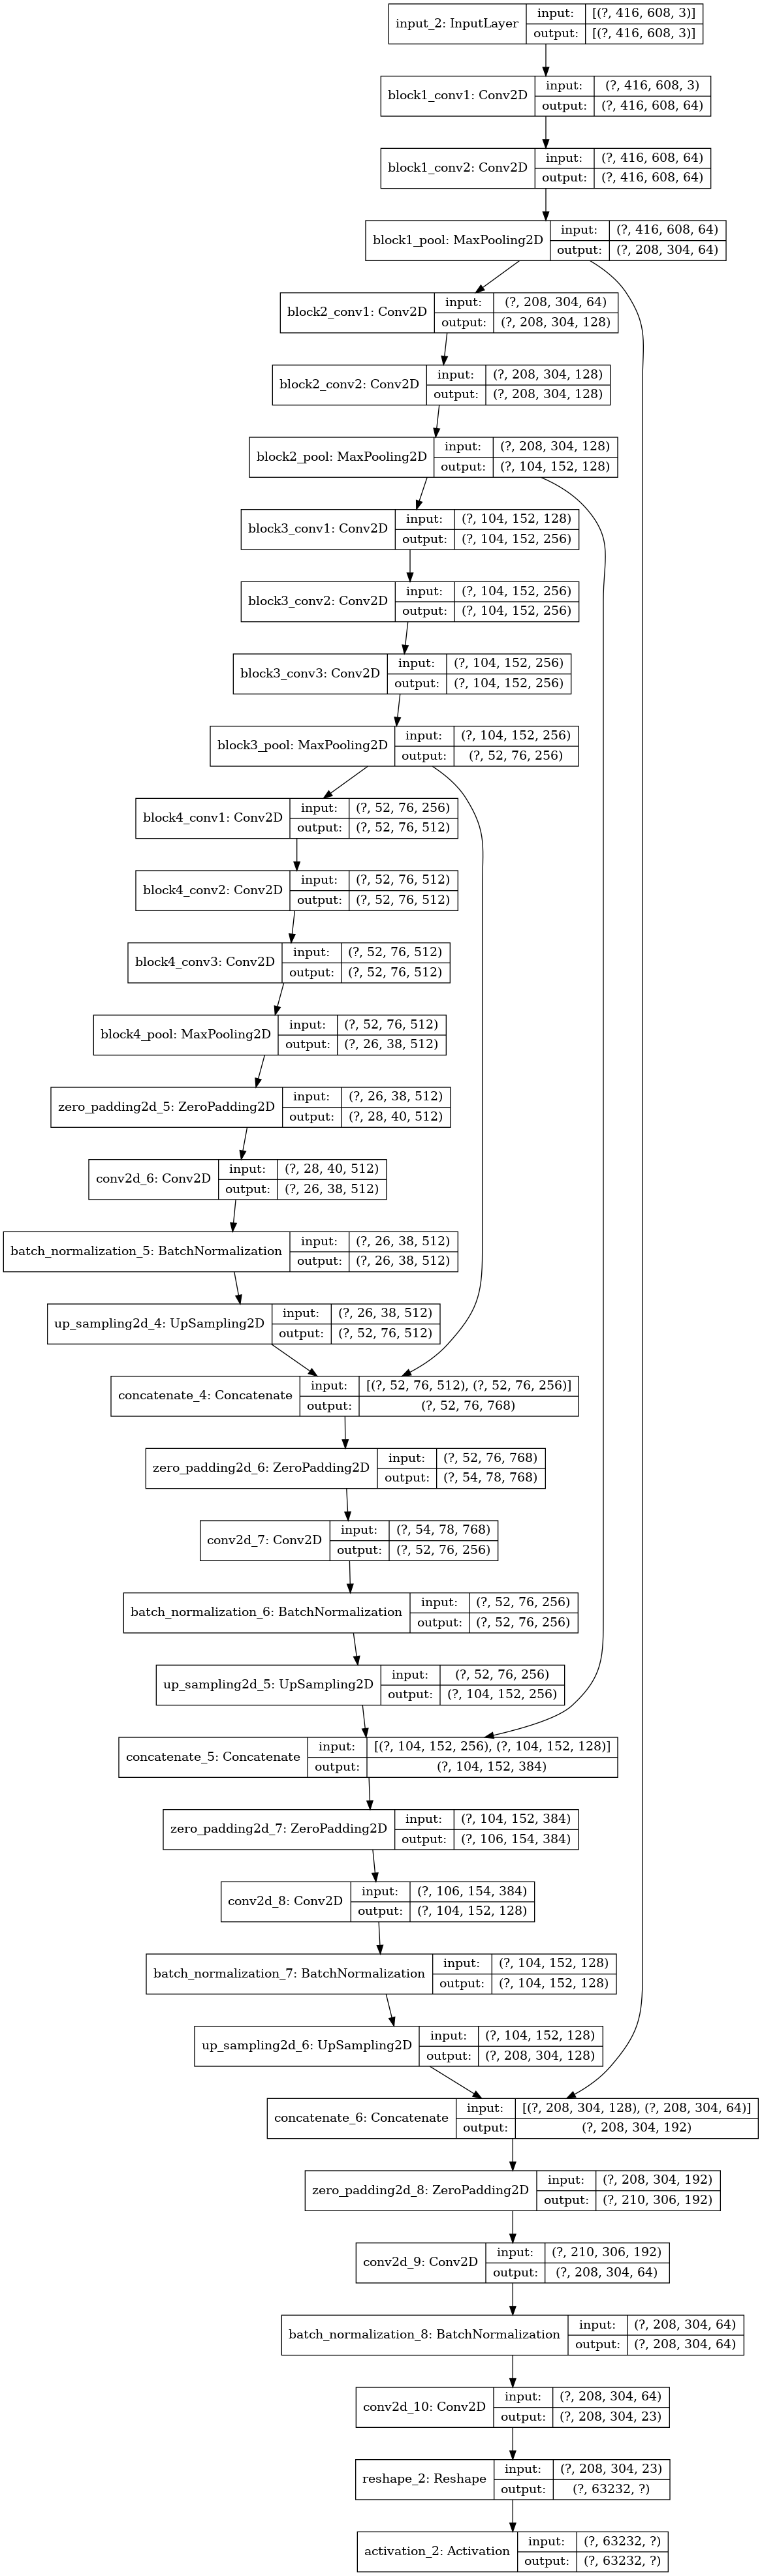

In [4]:
plot_model(model1, to_file='model_plot.png', show_shapes=True, show_layer_names=True)